# Amazon Alexa Review - Sentiment Analysis

Analyzing the Amazon Alexa dataset and building classification models to predict if the sentiment of a given input sentence is positive or negative.

### Importing required libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import pickle
import re

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\91798\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
%pip install xgboost

### Exploratory Data Analysis

In [4]:
#Load the data

data = pd.read_csv(r"text_emotion.csv")

print(f"Dataset shape : {data.shape}")

Dataset shape : (40000, 4)


In [5]:
data.head()

,tweet_id,sentiment,author,content
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!
4,1956968416,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...


In [6]:
#Column names

print(f"Feature names : {data.columns.values}")

Feature names : ['tweet_id' 'sentiment' 'author' 'content']


In [7]:
#Check for null values

data.isnull().sum()

tweet_id     0
sentiment    0
author       0
content      0
dtype: int64

There is one record with no 'verified_reviews' (null value)

In [8]:
#We will drop the null record

data.dropna(inplace=True)

In [9]:
print(f"Dataset shape after dropping null values : {data.shape}")

Dataset shape after dropping null values : (40000, 4)


In [10]:
#Creating a new column 'length' that will contain the length of the string in 'verified_reviews' column

data['length'] = data['content'].apply(len)

In [11]:
data.head()

,tweet_id,sentiment,author,content,length
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habi...,92
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...,60
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...,35
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!,36
4,1956968416,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...,86


The 'length' column is new generated column - stores the length of 'verified_reviews' for that record. Let's check for some sample records

In [12]:
#Randomly checking for 10th record

print(f"'verified_reviews' column value: {data.iloc[10]['content']}") #Original value
print(f"Length of review : {len(data.iloc[10]['content'])}") #Length of review using len()
print(f"'length' column value : {data.iloc[10]['length']}") #Value of the column 'length'

'verified_reviews' column value: cant fall asleep
Length of review : 16
'length' column value : 16


We can see that the length of review is the same as the value in the length column for that record

Datatypes of the features

In [13]:
data.dtypes

tweet_id      int64
sentiment    object
author       object
content      object
length        int64
dtype: object

* rating, feedback and length are integer values <br>
* date, variation and verified_reviews are string values

### Analyzing 'rating' column

This column refers to the rating of the variation given by the user

In [14]:
len(data)

40000

### Analyzing 'feedback' column

This column refers to the feedback of the verified review

In [15]:
#Distinct values of 'feedback' and its count 

print(f"Feedback value count: \n{data['sentiment'].value_counts()}")

Feedback value count: 
sentiment
neutral       8638
worry         8459
happiness     5209
sadness       5165
love          3842
surprise      2187
fun           1776
relief        1526
hate          1323
empty          827
enthusiasm     759
boredom        179
anger          110
Name: count, dtype: int64


There are 13 kind of sentimental emotions of the values in the 'sentiment' column. Let's see what kind of sentiment each content corresponds to.

feedback value = anger

In [16]:
#Extracting the 'verified_reviews' value for one record with feedback = 0

review_0 = data[data['sentiment'] == 'boredom'].iloc[1]['content']
print(review_0)

Waiting in line @ tryst


In [17]:
#Extracting the 'verified_reviews' value for one record with feedback = 1

review_1 = data[data['sentiment'] == 'fun'].iloc[1]['content']
print(review_1)

@DavidArchie &lt;3 your gonna be the first  twitter ;) cause your amazing lol. come to canada  would do anything to see you perform


From the above 2 examples we can see some Sentiment **Boredom** and **fun**

Let's plot the feedback value count in a bar graph

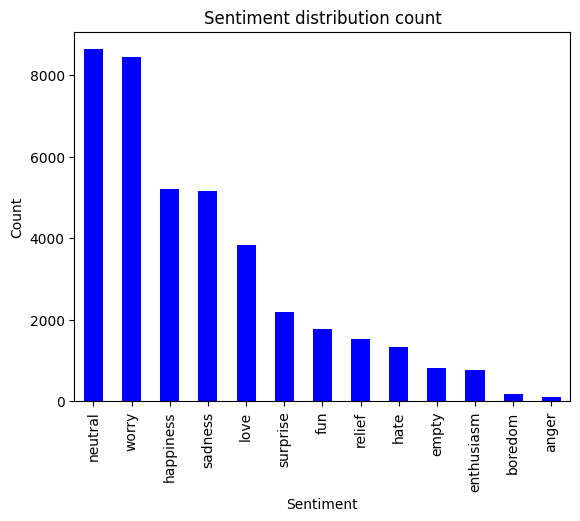

In [18]:
#Bar graph to visualize the total counts of each feedback

data['sentiment'].value_counts().plot.bar(color = 'blue')
plt.title('Sentiment distribution count')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

In [19]:
unique_labels = data['sentiment'].unique()
u = list(unique_labels)

In [20]:
#Finding the percentage distribution of each feedback - we'll divide the number of records for each feedback by total number of records

print(f"Sentiment value count - percentage distribution: \n{round(data['sentiment'].value_counts()/data.shape[0]*100,2)}")

Sentiment value count - percentage distribution: 
sentiment
neutral       21.60
worry         21.15
happiness     13.02
sadness       12.91
love           9.60
surprise       5.47
fun            4.44
relief         3.82
hate           3.31
empty          2.07
enthusiasm     1.90
boredom        0.45
anger          0.27
Name: count, dtype: float64


Feedback distribution <br>
* 2.07% are empty sentiment <br>
* 
12.91% are sadness sentimen <br>t* 
1.9% are enthusiasm sentime <br>n* t
21.59% are neutral sentim <br>e* nt
21.15% are worry senti <br>m* ent
5.47% are surprise sent <br>i* ment
9.61% are love sen <br>t* iment
4.44% are fun se <br>n* timent
3.31% are hate s <br>e* ntiment
13.02% are happiness  <br>s* entiment
0.45% are boredom <br> * sentiment
3.82% are relie <br>f*  sentiment
0.27% are anger sentiment

In [21]:
data['length'].describe()

count    40000.000000
mean        73.405550
std         36.558015
min          1.000000
25%         43.000000
50%         69.000000
75%        103.000000
max        167.000000
Name: length, dtype: float64

Length analysis for full dataset

[Text(0.5, 1.0, 'Distribution of length of contents(Tweets)')]

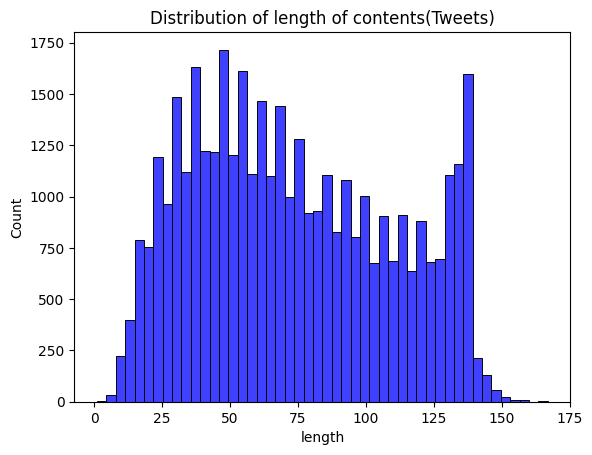

In [22]:
sns.histplot(data['length'],color='blue').set(title='Distribution of length of contents(Tweets)')

Length analysis when feedback is 0 (negative)

[Text(0.5, 1.0, 'Distribution of length of tweet if sentiment = anger')]

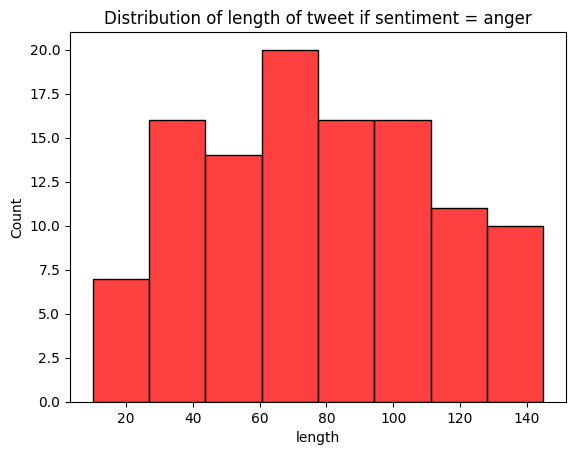

In [23]:
sns.histplot(data[data['sentiment']=='anger']['length'],color='red').set(title='Distribution of length of tweet if sentiment = anger')

[Text(0.5, 1.0, 'Distribution of length of tweet if sentiment = boredom')]

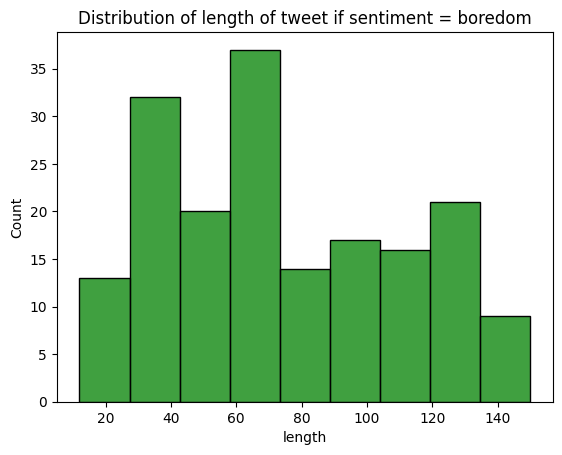

In [24]:
sns.histplot(data[data['sentiment']=='boredom']['length'],color='green').set(title='Distribution of length of tweet if sentiment = boredom')

In [25]:
cv = CountVectorizer(stop_words='english')
words = cv.fit_transform(data.content)

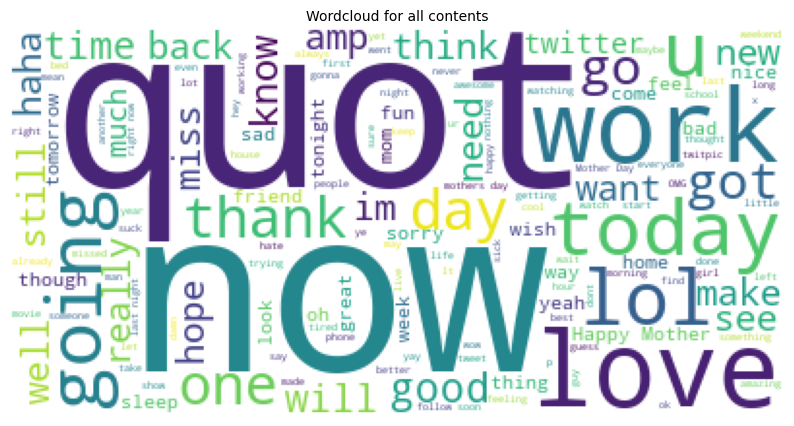

In [26]:
# Combine all reviews
contents = " ".join([review for review in data['content']])
                        
# Initialize wordcloud object
wc = WordCloud(background_color='white', max_words=500)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(contents))
plt.title('Wordcloud for all contents', fontsize=10)
plt.axis('off')
plt.show()

Lets find the unique words in each feedback category

In [27]:
# Combine all contents for each sentiment category and splitting them into individual words
contents_dict = {}
for i in data['sentiment'].unique():
    contents_dict[i] = " ".join([contents for contents in data[data['sentiment'] == i]['content']])
    contents_dict[i] = contents_dict[i].lower().split()

In [28]:
#Finding words from contents which are present in that sentiment category only
contents_uniqe_dict = {}
for i in data['sentiment'].unique():
    remain_dict = {key: value for key, value in contents_dict.items() if key != i}
    contents_uniqe_dict[i] = [x for x in contents_dict[i] if x not in remain_dict.values()]
    contents_uniqe_dict[i] = " ".join(contents_uniqe_dict[i])

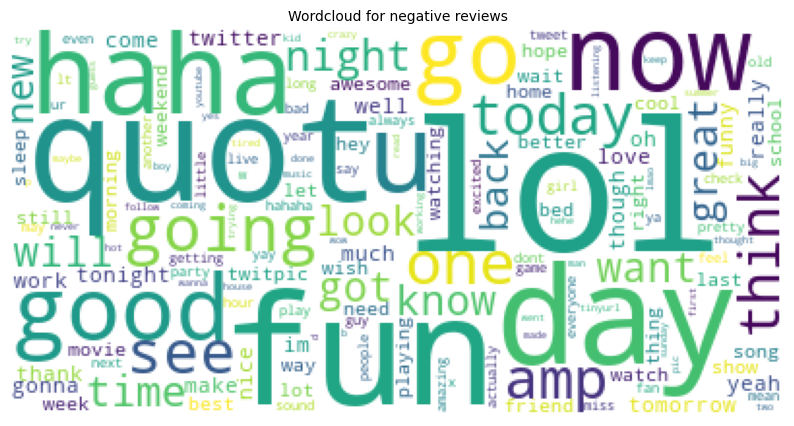

In [29]:
wc = WordCloud(background_color='white', max_words=500)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(contents_uniqe_dict['fun']))
plt.title('Wordcloud for negative reviews', fontsize=10)
plt.axis('off')
plt.show()

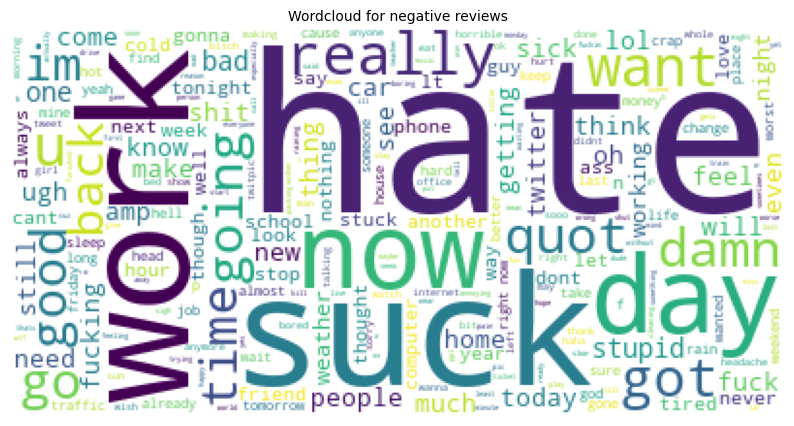

In [30]:
# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(contents_uniqe_dict['hate']))
plt.title('Wordcloud for negative reviews', fontsize=10)
plt.axis('off')
plt.show()

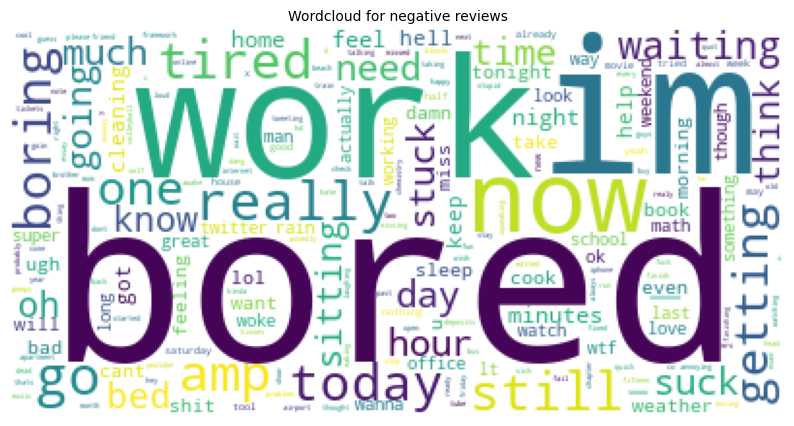

In [31]:
# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(contents_uniqe_dict['boredom']))
plt.title('Wordcloud for negative reviews', fontsize=10)
plt.axis('off')
plt.show()

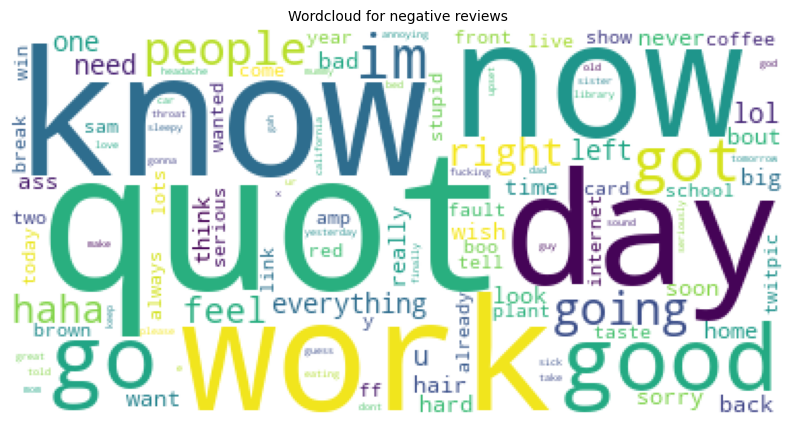

In [32]:
# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(contents_uniqe_dict['anger']))
plt.title('Wordcloud for negative reviews', fontsize=10)
plt.axis('off')
plt.show()

These are some WordCloud for 

# Preprocessing and Modelling

To build the corpus from the 'Contents(from Twitter)' we perform the following - <br>
1. Replace any non alphabet characters with a space
2. Covert to lower case and split into words
3. Iterate over the individual words and if it is not a stopword then add the stemmed form of the word to the corpus

In [33]:
corpus = []
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

for i in range(0,data.shape[0]):  # Limiting to first 10 rows for demonstration
    content = re.sub('[^a-zA-Z]', ' ', str(data.iloc[i]['content']))
    content = content.lower().split()
    content = [stemmer.stem(word) for word in content if word not in stop_words]
    content = ' '.join(content)
    corpus.append(content)

Using Count Vectorizer to create bag of words

In [34]:
cv = CountVectorizer(max_features = 10000)

#Storing independent and dependent variables in X and y
X = cv.fit_transform(corpus).toarray()
y = data['sentiment'].values

In [35]:
#Saving the Count Vectorizer
pickle.dump(cv, open('Models/countVectorizer2.pkl', 'wb'))

Checking the shape of X and y

In [36]:
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (40000, 10000)
y shape: (40000,)


Splitting data into train and test set with 30% data with testing.

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 15)

print(f"X train: {X_train.shape}")
print(f"y train: {y_train.shape}")
print(f"X test: {X_test.shape}")
print(f"y test: {y_test.shape}")

X train: (28000, 10000)
y train: (28000,)
X test: (12000, 10000)
y test: (12000,)


In [38]:
print(f"X train max value: {X_train.max()}")
print(f"X test max value: {X_test.max()}")

X train max value: 9
X test max value: 9


We'll scale X_train and X_test so that all values are between 0 and 1.

In [39]:
scaler = MinMaxScaler()

X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.transform(X_test)

In [40]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform labels in y_train and y_test
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [41]:
#Saving the scaler model
pickle.dump(scaler, open('Models/scaler.pkl', 'wb'))

In [42]:
# Define the neural network model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scl.shape[1],)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(len(np.unique(y)), activation='softmax')
])

c:\Users\91798\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [43]:
# Compile the model
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [47]:
history = model.fit(X_train_scl, y_train_encoded, epochs=5, batch_size=32, validation_split=0.2)

Epoch 1/5
700/700 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7355 - loss: 0.8223 - val_accuracy: 0.3152 - val_loss: 3.0369
Epoch 2/5
700/700 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7493 - loss: 0.7710 - val_accuracy: 0.3123 - val_loss: 3.1568
Epoch 3/5
700/700 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7755 - loss: 0.7141 - val_accuracy: 0.3116 - val_loss: 3.2747
Epoch 4/5
700/700 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7772 - loss: 0.6973 - val_accuracy: 0.3057 - val_loss: 3.4486
Epoch 5/5
700/700 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7925 - loss: 0.6498 - val_accuracy: 0.3096 - val_loss: 3.6466


In [48]:
# Train the model
train_loss, train_accuracy = model.evaluate(X_train_scl, y_train_encoded)
print("Training Accuracy:", train_accuracy)

875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8895 - loss: 0.4229
Training Accuracy: 0.7828928828239441


In [49]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test_scl, y_test_encoded)
print("Testing Accuracy:", test_accuracy)

375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3012 - loss: 3.7389
Testing Accuracy: 0.29374998807907104


#### Random Forest

In [50]:
#Fitting scaled X_train and y_train on Random Forest Classifier
model_rf = RandomForestClassifier()
model_rf.fit(X_train_scl, y_train)

RandomForestClassifier()

In [51]:
#Accuracy of the model on training and testing data
 
print("Training Accuracy :", model_rf.score(X_train_scl, y_train))
print("Testing Accuracy :", model_rf.score(X_test_scl, y_test))

Training Accuracy : 0.9767142857142858
Testing Accuracy : 0.31016666666666665


In [52]:
#Predicting on the test set
y_preds = model_rf.predict(X_test_scl)

In [53]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)

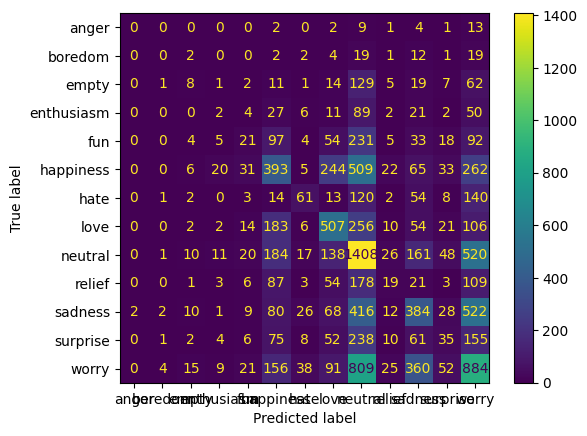

In [54]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_rf.classes_)
cm_display.plot()
plt.show()

K fold cross-validation

In [83]:
accuracies = cross_val_score(estimator = model_rf, X = X_train_scl, y = y_train, cv = 10)

print("Accuracy :", accuracies.mean())
print("Standard Variance :", accuracies.std())

KeyboardInterrupt: 

Applying grid search to get the optimal parameters on random forest

In [ ]:
params = {
    'bootstrap': [True],
    'max_depth': [80, 100],
    'min_samples_split': [8, 12],
    'n_estimators': [100, 300]
}

In [ ]:
cv_object = StratifiedKFold(n_splits = 2)

grid_search = GridSearchCV(estimator = model_rf, param_grid = params, cv = cv_object, verbose = 0, return_train_score = True)
grid_search.fit(X_train_scl, y_train.ravel())

In [60]:
#Getting the best parameters from the grid search


print("Best Parameter Combination : {}".format(grid_search.best_params_))

Best Parameter Combination : {'bootstrap': True, 'max_depth': 80, 'min_samples_split': 8, 'n_estimators': 300}


In [61]:
print("Cross validation mean accuracy on train set : {}".format(grid_search.cv_results_['mean_train_score'].mean()*100))
print("Cross validation mean accuracy on test set : {}".format(grid_search.cv_results_['mean_test_score'].mean()*100))
print("Accuracy score for test set :", accuracy_score(y_test, y_preds))

Cross validation mean accuracy on train set : 33.33333333333333
Cross validation mean accuracy on test set : 16.666666666666664
Accuracy score for test set : 0.3333333333333333


#### XgBoost

In [62]:
model_xgb = XGBClassifier()
model_xgb.fit(X_train_scl, y_train)

ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2 3], got ['enthusiasm' 'neutral' 'sadness' 'worry']

In [63]:
#Accuracy of the model on training and testing data
 
print("Training Accuracy :", model_xgb.score(X_train_scl, y_train))
print("Testing Accuracy :", model_xgb.score(X_test_scl, y_test))

NotFittedError: need to call fit or load_model beforehand

In [64]:
y_preds = model_xgb.predict(X_test)

NotFittedError: need to call fit or load_model beforehand

In [65]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)
print(cm)

[[0 1 0]
 [0 1 0]
 [0 1 0]]


ValueError: The number of FixedLocator locations (3), usually from a call to set_ticks, does not match the number of labels (4).

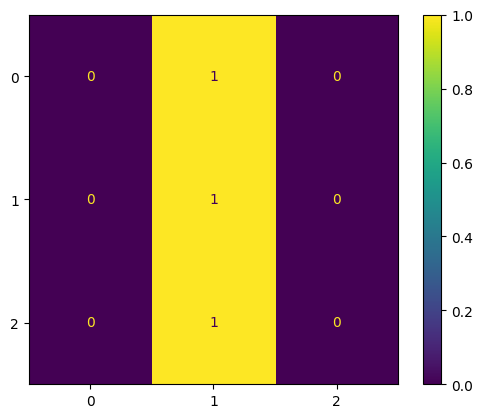

In [66]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_xgb.classes_)
cm_display.plot()
plt.show()

In [67]:
#Saving the XGBoost classifier
pickle.dump(model_xgb, open('Models/model_xgb.pkl', 'wb'))

#### Decision Tree Classifier

In [68]:
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train_scl, y_train)

DecisionTreeClassifier()

In [69]:
#Accuracy of the model on training and testing data
 
print("Training Accuracy :", model_dt.score(X_train_scl, y_train))
print("Testing Accuracy :", model_dt.score(X_test_scl, y_test))

Training Accuracy : 0.3333333333333333
Testing Accuracy : 0.3333333333333333


In [70]:
y_preds = model_dt.predict(X_test)

In [71]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)
print(cm)

[[0 1 0]
 [0 1 0]
 [0 1 0]]


ValueError: The number of FixedLocator locations (3), usually from a call to set_ticks, does not match the number of labels (4).

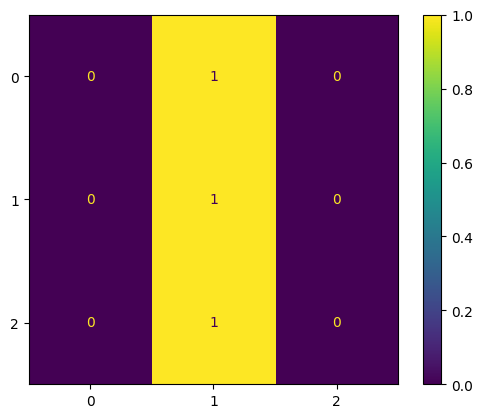

In [72]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_dt.classes_)
cm_display.plot()
plt.show()

In [1]:
import tensorflow

In [3]:
import tensorflow

In [4]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

C:\Users\91798\AppData\Local\Temp\ipykernel_5136\2445239779.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
